# How to use this notebook

Sections 1 and 2 require data external to this repo to replicate. You can [download those data here](https://berkeley.box.com/s/je4ld219m7somvqmb9bqu2v7z3il3n48).

**Section 1. Data import and cleaning**. This section marshals and cleans the source ICLab dataset. It takes as input `combined.csv` (download above) and produces `iclab-cleaned-fortiguard.csv`.

**Section 2. Experiments**. This walks through the various experiments we undertook to produce our metric. It starts by loading `iclab-cleaned-fortiguard.csv` and finishes by producing `metrics.csv`.

**Section 3. Hypothesis testing**. This does our directed hypothesis testing and correlation testing with other metrics. It starts by loading `metrics.csv` and does not produce any output to disk.

Run the two cells below to install and import all the libraries you will need to run any section of this notebook.


In [1]:
!pip install tldextract
!pip install pycountry
!pip install jupyterthemes

You are using pip version 18.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 18.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 18.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import pandas as pd
import os
import re
import tldextract
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import spatial
import os, time, http.client
from termcolor import colored
import sys
import json
from pygments import highlight, lexers, formatters
import pycountry
import scipy
from scipy import stats
from scipy.stats import ttest_ind, ttest_ind_from_stats
from scipy.special import stdtr
import statistics

# Tools for visualizing the data

# requires jupytertehmes

%pylab inline
# import jtplot module in notebook
from jupyterthemes import jtplot

# choose which theme to inherit plotting style from
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.style(theme='grade3')

# set "context" (paper, notebook, talk, poster)
# scale font-size of ticklabels, legend, etc.
# remove spines from x and y axes and make grid dashed
jtplot.style(context='paper', fscale=1.4, spines=False, gridlines='--')

# turn on X- and Y-axis tick marks (default=False)
# turn off the axis grid lines (default=True)
# and set the default figure size
jtplot.style(ticks=True, grid=False, figsize=(6, 4.5))



# utility functions

def get_blocked_sites_indices (df): 
    return (
        (df['dns_all']==True) | 
        (df['censored_updated']==True) | 
        (df['block']==True) | 
        (df['packet_updated']==True)
    )


Populating the interactive namespace from numpy and matplotlib


# Section 1. Data import and cleaning

This section imports and cleans  all the [ICLab data](https://iclab.org/post/iclab_data/) as of this writing, 2020-07-22. 

If you want to add new data, or clean our data differently, edit this section.

**If you are interested in metric computation or hypothesis testing, SKIP THIS SECTION. You can load the cleaned data at the beginning of Sections 2 and 3**.

If you would like to continue, you'll need to [download combined.csv here](https://berkeley.box.com/s/je4ld219m7somvqmb9bqu2v7z3il3n48). This is a large (8GB) file.
It is created by concatenating all of the ICLab data (see link above).

In [3]:
# make sure you've downloaded combined.csv - see link above.
# WARNING - this is a large dataset and will produce some memory pressure.
iclabcombined = pd.read_csv("../data/combined.csv", dtype={'country' : str})

/home/ffff/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (3,6,7,10,11,12,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Clean ICLab dataset

Drop the columns which were meant for internal use of ICLAB team and the header columns which have come into dataset via join.

In [4]:
iclabcombined.drop(['filename', 'as_number'], axis=1, inplace= True)

iclabcombined.drop([ 3078134,  4235577, 12411076, 18967078, 25041685, 26600938,
            28192530, 29460039, 30795516, 32569776, 34391850, 36093972,
            37793956, 39298313, 40934970, 42276914, 42976448, 44455181,
            47068048, 49383978], inplace = True)

Correcting wrongly coded boolean values in the datasets

In [5]:
iclabcombined['dns'].replace('false',False,inplace=True)
iclabcombined['dns_all'].replace('false',False,inplace=True)
iclabcombined['block'].replace('false',False,inplace=True)
iclabcombined['packet_updated'].replace('false',False,inplace=True)
iclabcombined['censored_updated'].replace('false',False,inplace=True)

iclabcombined['dns'].replace('true',True,inplace=True)
iclabcombined['dns_all'].replace('true',True,inplace=True)
iclabcombined['block'].replace('true',True,inplace=True)
iclabcombined['packet_updated'].replace('true',True,inplace=True)
iclabcombined['censored_updated'].replace('true',True,inplace=True)

##  Merge ICLab dataset wtih Fortiguard categories

We'll also be importing the Fortiguard categories for each URL blocked, and merging them into our dataset of blocking observations.

The result will be a list of ICLab blocking observations, along with the Fortiguard category for each URL observed.

We'll start with a list of domain mappings that comes with the ICLab dataset.

In [6]:
catDF = pd.read_fwf('../data/utils/type_domain_mapping.txt',header=None, names=[ "Name"], sep="")

In [7]:
catDF = catDF.Name.apply(lambda x: pd.Series(str(x).split("|||"))).rename(columns={0:'category',1:'site'})

In [8]:
allCategories = set(catDF['category'])
len(allCategories)

80

In [9]:
# ADDING CATEGORY AS A PERMANENT COLUMN
urlListAll = iclabcombined['url'].tolist()
sitesListAll = []
for item in urlListAll:
    domainAll = tldextract.extract(item)[1]
    suffixAll = tldextract.extract(item)[2]
    sitesListAll.append(domainAll + "." + suffixAll)

In [10]:
iclabcombined['site'] = sitesListAll
iclabcombined = pd.merge(iclabcombined, catDF, on='site',how='left')

In [11]:
iclabcombined['category'] = iclabcombined['category'].fillna(0)
iclabcombined['category']=iclabcombined['category'].replace(0,'Undefined')
iclabcombined.head()

,server_t,country,schedule_name,url,dns,dns_reason,dns_all,dns_reason_all,http_status,block,body_len,http_reason,packet_updated,packet_reason,censored_updated,site,category
0,2017-01-01T00:03:55.797Z,UA,alexa-global,4shared.com,False,sameip,False,NaN,200,False,89694,NaN,NaN,NaN,False,4shared.com,File Sharing and Storage
1,2017-01-01T00:03:55.797Z,UA,alexa-global,quora.com,-2,no_control_resp,False,NaN,200,False,99907,NaN,NaN,NaN,False,quora.com,Reference
2,2017-01-01T00:03:55.797Z,UA,alexa-global,stackexchange.com,-2,no_control_resp,False,NaN,200,False,83096,NaN,NaN,NaN,False,stackexchange.com,Information Technology
3,2017-01-01T00:03:55.797Z,UA,alexa-global,whatsapp.com,-2,no_control_resp,False,NaN,200,False,32799,NaN,NaN,NaN,False,whatsapp.com,Instant Messaging
4,2017-01-01T00:03:55.797Z,UA,alexa-global,atlassian.net,-2,no_control_resp,False,NaN,200,False,38180,NaN,NaN,NaN,False,atlassian.net,Information Technology


Now we're going to save this to CSV. This allows us to save time and memory.

In [12]:
iclabcombined.to_csv('../data/iclab_cleaned_data/iclab-cleaned.csv')

## Adding missing Fortiguard categories
Unfortunately, not all Fortiguard categories come shipped with ICLab. We have to augment this list, adding to it by scraping Fortiguard ourselves.

I recommend restarting your Jupyter kernel now. That will clear your memory out. Then you can load this file again and do the remaining data cleaning steps.

You could beenfit from access to our Fortiguard database to replicate this step. Please contact the research team if you would like to request access.  However, access is not absolutely required. See `config.example.py` for an example on how to point to your Postgres instance. Then use `create-tables.py` to set up your Postgres database to take this format. You can use this code to create your own cache of Fortiguard categories without access to our database.

In [5]:
iclabcombined = pd.read_csv('../data/iclab_cleaned_data/iclab-cleaned.csv').drop(columns=["Unnamed: 0"])

/home/ffff/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
print("The number of observations in our original data set are {0} and the number of features/columns are {1} ".format(iclabcombined.shape[0],iclabcombined.shape[1]))

The number of observations in our original data set are 50436846 and the number of features/columns are 17 


In [14]:
blocked_sites_indices =  get_blocked_sites_indices(iclabcombined)

print("{0} sites are blocked, or {1}% of the dataset".format(
    len(iclabcombined[blocked_sites_indices]), 
    (len(blocked_sites[blocked_sites_indices])/len(iclabcombined))*100
))

232348 sites are blocked, or 0.4606711529900185% of the dataset


In [15]:
import requests 
from time import sleep
from bs4 import BeautifulSoup
from typing import Optional

from config import config

# # Find Fortiguard categories
#
# We now want to get the Fortiguard categories for all the URLs. This tells us
# (very roughly) what the websites are "about."

def query_fortiguard_category (url) -> str:
    html_doc = requests.get('https://fortiguard.com/webfilter?q={!s}'.format(url)).text
    soup = BeautifulSoup(html_doc, 'html.parser')
    return soup.h4.get_text().split(': ')[1]

def lookup_category (cursor, url) -> str:
    cursor.execute("SELECT fortiguard_category FROM fortiguard_categories WHERE url='{!s}'".format(url))
    return cursor.fetchone()[0]

def get_fortiguard_category (cursor, url) -> Optional[str]:
    '''Get the Fortiguard category for a given URL. We'll check our database
    first. If we can't find the category there, we will scrape Fortiguard's
    webpage to get the category. '''
    # try to retrieve the category from the database
    try:
        category = lookup_category(cursor, url)
        return category
    # if we can't find it,
    except TypeError:
#         print('querying', url)
        try:
            # sleep so as to not overwhelm the endpoint
            sleep(config['sleep-times']['fortiguard'])
            # now query it
            category = query_fortiguard_category(url)
            # add url/cateogry mapping to database
            insert_fortiguard_category(cur, url, category)
            conn.commit()
            # return the category
            return category
        # if there's some other error,
        except:
            # return None
            return None

## Database stuff

def insert_fortiguard_category (cursor, url, category):
    cursor.execute("""
    INSERT INTO fortiguard_categories
    (url, fortiguard_category)
    VALUES
    (%s, %s)
    """, (
        url,
        category,
    ))


In [39]:
import psycopg2

conn = psycopg2.connect(**config['postgres'])
print("Made connection to the database:")
cur = conn.cursor()
print("Made database cursor.")

Made connection to the database:
Made database cursor.


In [36]:
undefined_sites_indices = iclabcombined['category']=='Undefined' 
# undefined_sites = undefined_sites[undefined_sites==True]
# len(undefined_sites) #/ len(iclabcombined)
blocked_and_undefined_category =  iclabcombined[(undefined_sites_indices & blocked_sites_indices)]
num_to_process = len(blocked_and_undefined_category)
num_to_process, "blocked websites with no known category"

(23, 'blocked websites with no known category')

In [40]:
records_processed = 1
csv_out_path = '../data/iclab_cleaned_data/iclab-cleaned-fortiguard.csv'

for i, _ in blocked_and_undefined_category.iterrows():
    if records_processed % 1000 == 0:
        percent_done = (records_processed / num_to_process)*100
        print('{0}% done'.format(percent_do))
    record = iclabcombined.iloc[i]
    site = record['site']
    # check db to see if we've dl'd category
    # if not, scrape fortiguard for website & add category to db
    category = get_fortiguard_category(cur, site)
    # if we found a category, update it in iclabcombined
    if category:
        iclabcombined.at[i, 'category'] = category
    else:
        print(i, 'Some issue scraping category for', site)
    # every few thousand items we scrape, we save
    if records_processed % 5000 == 0:
        print(records_processed, 'saving notebook')
        iclabcombined.to_csv(csv_out_path)
    records_processed+=1

# save after everything a well        
iclabcombined.to_csv(csv_out_path)

In [41]:
conn.close()
cur.close()

# Section 2.  Running experiments

In this section, we walk through the metrics with which we experimented in our paper.

At the end of this section, we produce `data/MetricDF.csv`, which contains all of our final metrics and associated data.

If you have NOT run Section 1, above, you'll need to [download iclab-clean-fortiguard.csv here](https://berkeley.box.com/s/je4ld219m7somvqmb9bqu2v7z3il3n48).

In [4]:
# WARNING - this is a pretty big file, and will prdouce some memory pessure
iclabCLEAN = pd.read_csv('../data/iclab_cleaned_data/iclab-cleaned-fortiguard.csv').drop(columns=["Unnamed: 0"])

/home/ffff/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [24]:
blocked_indices = get_blocked_sites_indices(iclabCLEAN)

def blocked_in (cc2) -> set:
    '''Get websites blocked in country by Country Code alpha 2'''
    return set(iclabCLEAN[(iclabCLEAN['country']==cc2) & (blocked_indices)]['url'])

## Dropping false positives

Since the US and NL don't 't have any blocked websites (net neturality laws + no censorship), we'll assume these URLs represent false positives throughout the dataset.

Whenever these URLs appear as blocked in the dataset, we'll drop them from the blocked indices, effectively ignoring them in future analysis.

UPDATE: We don't do this anymore.

In [26]:
# # what's 'blocked' in canada but not in the US?
# blocked_in('CA').difference(blocked_in('US'))
# sears.com redirects to sears.ca

In [27]:
# false_positives = blocked_in('US').union(blocked_in('NL'))
# num_to_clean = len(false_positives)
# num_to_clean

In [28]:
# len(blocked_indices)

In [189]:
# blocked_subset = iclabCLEAN[(blocked_indices)]

In [190]:
# indices_to_drop = []
# for url in false_positives:
#     matches = blocked_subset[blocked_subset['url']==url]
#     indices_to_drop.append(matches.index)

In [29]:
# def flatten (lst):
#     return [item for sublist in lst for item in sublist]
    
# indices_to_drop = flatten([i.tolist() for i in indices_to_drop])
# for i in indices_to_drop:
#     # change from True to False
#     blocked_indices.at[i] = False

## Experiment 1: Exact URL blocking

In [30]:
blockpageTR = blocked_in('TR')
len(blockpageTR)

121

In [31]:
blockpageRU = blocked_in('RU')
len(blockpageRU)

340

In [33]:
len(blockpageTR.intersection(blockpageRU))

23

## Experiment 2: Fuzzy blocking

As part of Experiment 2 : 
(a) A look at censored FB Pages in India

Looking at worldwide distribution of FB blocking

A look into religious censorship in the world

In [34]:
iclabCLEAN[ (iclabCLEAN['category'].isin(['Global Religion','Alternative Beliefs'])) & 
           (blocked_indices) ].groupby(['country', 'site']).first()

server_t      schedule_name  \
country site                                                                 
AU      atheists.org           2017-05-13T05:26:59.337Z  citizenlab-global   
        goarch.org             2017-07-15T20:13:06.090Z  citizenlab-global   
BG      buddhanet.net          2017-02-09T04:41:30.879Z  citizenlab-global   
BR      jesussaves.cc          2017-03-25T11:35:12.374Z  citizenlab-global   
BZ      buddhanet.net          2017-01-03T00:00:42.387Z  citizenlab-global   
...                                                 ...                ...   
US      christianitytoday.com  2017-01-10T05:30:29.086Z  citizenlab-global   
        jesussaves.cc          2017-03-25T01:58:48.819Z  citizenlab-global   
        pcusa.org              2017-01-16T19:12:09.571Z  citizenlab-global   
        wcicc.org              2018-02-20T17:12:15.660Z  citizenlab-global   
VN      buddhanet.net          2017-01-17T00:49:22.933Z  citizenlab-global   

                                                            url    dns  \
country site                                                             
AU      atheists.org                   http://www.atheists.org/    NaN   
        goarch.org                       http://www.goarch.org/  False   
BG      buddhanet.net                  http://www.buddhanet.net  False   
BR      jesussaves.cc                 http://www.jesussaves.cc/   True   
BZ      buddhanet.net                  http://www.buddhanet.net  False   
...                                                         ...    ...   
US      christianitytoday.com  http://www.christianitytoday.com  False   
        jesussaves.cc                 http://www.jesussaves.cc/  False   
        pcusa.org                          http://www.pcusa.org  False   
        wcicc.org                         http://www.wcicc.org/    NaN   
VN      buddhanet.net                  http://www.buddhanet.net  False   

                                        dns_reason dns_all  \
country site                                                 
AU      atheists.org                           NaN     NaN   
        goarch.org                          sameas   False   
BG      buddhanet.net                       sameip   False   
BR      jesussaves.cc          ip_in_other_regions    True   
BZ      buddhanet.net                       sameip   False   
...                                            ...     ...   
US      christianitytoday.com               sameip   False   
        jesussaves.cc          ip_in_other_regions    True   
        pcusa.org                           sameip   False   
        wcicc.org                              NaN      -2   
VN      buddhanet.net                       sameip   False   

                                    dns_reason_all  http_status  block  \
country site                                                             
AU      atheists.org                           NaN        403.0  False   
        goarch.org                             NaN        200.0  False   
BG      buddhanet.net                          NaN        200.0  False   
BR      jesussaves.cc          ip_in_other_regions         -1.0  False   
BZ      buddhanet.net                          NaN        200.0  False   
...                                            ...          ...    ...   
US      christianitytoday.com                  NaN         -1.0  False   
        jesussaves.cc          ip_in_other_regions        200.0  False   
        pcusa.org                              NaN        200.0  False   
        wcicc.org                  no_control_node         -1.0  False   
VN      buddhanet.net                          NaN         -1.0  False   

                               body_len http_reason packet_updated  \
country site                                                         
AU      atheists.org             3293.0          {}           True   
        goarch.org             106762.0          {}           True   
BG      buddhanet.n

## Experiment 3: Blocking by content category (our final metric)


In [35]:
def Category_contributions(cc):
    '''
    Computes contribution of each category in a countries blocked sites*
    '''
    catDataCC = iclabCLEAN[(iclabCLEAN['country']==cc) & (blocked_indices) ]
    catDataCC= catDataCC.drop(['server_t', 'censored_updated','site','dns_all','packet_reason','url','dns','dns_reason','dns_reason_all','schedule_name','http_status','block','body_len','http_reason','packet_updated'], axis=1)
    catDataCC = catDataCC.groupby('category').count()
    catDataCC['%Cat'] = (catDataCC['country']*100)/(catDataCC['country'].sum())
    catDataCC= catDataCC.reset_index().drop('country',axis=1)
    catDataCC= catDataCC.rename(columns={'country':'Number of sites in' + str(cc),'%Cat':cc})
    return catDataCC

In [36]:
# Category_contributions('CA')
Category_contributions('TR')

,category,TR
0,Advocacy Organizations,0.769654
1,Brokerage and Trading,0.604728
2,Education,1.099505
3,Entertainment,2.803738
4,Explicit Violence,0.329852
5,File Sharing and Storage,1.594283
6,Gambling,3.848268
7,Games,0.714678
8,General Organizations,1.979109
9,Global Religion,1.154480


In [37]:
INplot = Category_contributions('IN')
TRplot =Category_contributions('TR')
RUplot = Category_contributions('RU')
KRplot= Category_contributions('KR')
USplot = Category_contributions('US')
CNplot = Category_contributions('CN')
CAplot  = Category_contributions('CA')
ZAplot  = Category_contributions('ZA')

 Plotting the graph below:

In [38]:
graphcompare1 = pd.merge(INplot,TRplot, on='category', how='outer')
graphcompare2 = pd.merge(graphcompare1,KRplot, on='category', how='outer')
graphcompare3 = pd.merge(graphcompare2,RUplot, on='category', how='outer')
graphcompare4 = pd.merge(graphcompare3,USplot, on='category', how='outer')
graphcompare5 = pd.merge(graphcompare4,CNplot, on='category', how='outer')

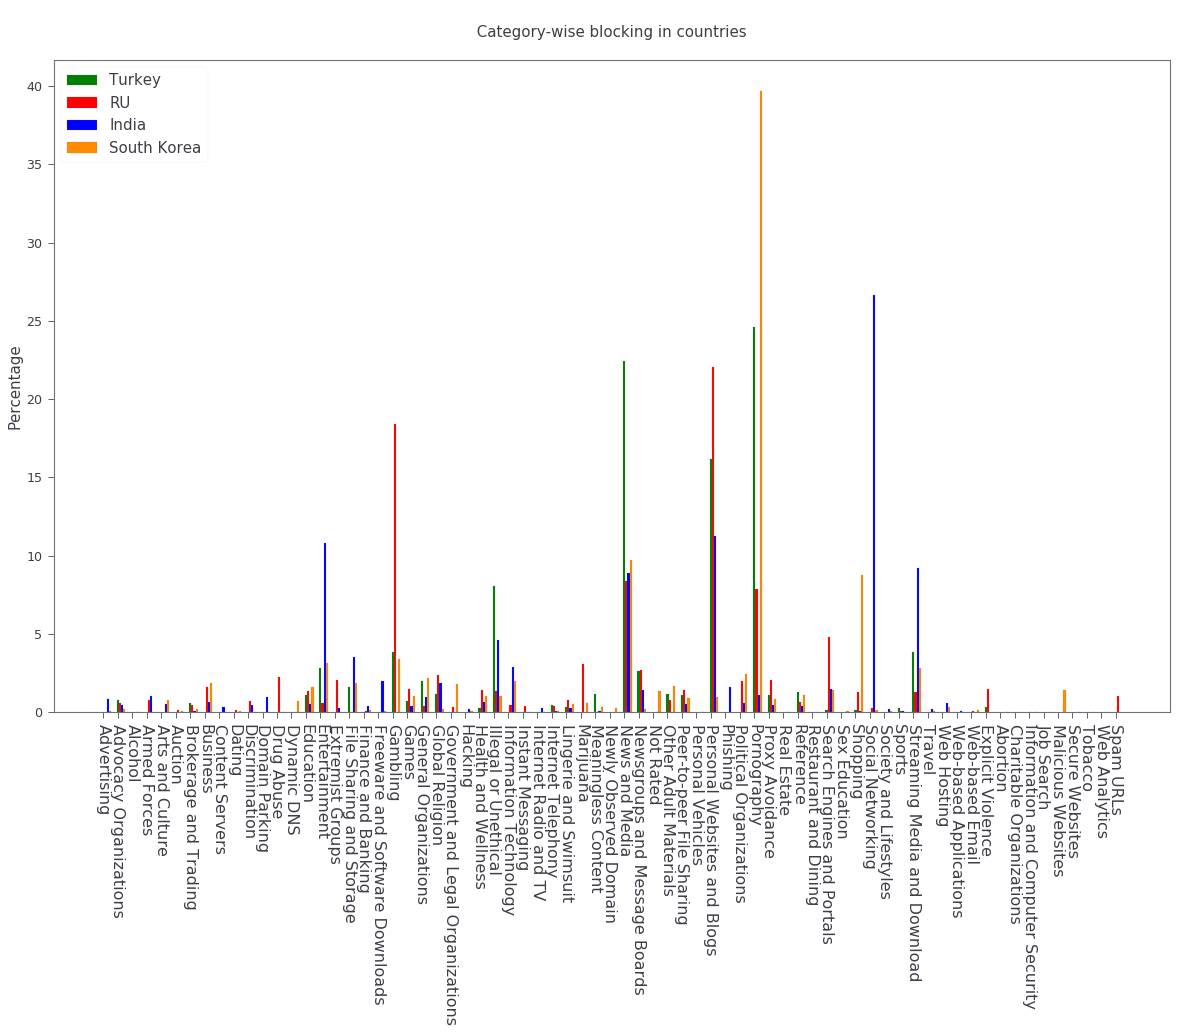

In [39]:
# set width of bar
barWidth = 0.15
 
# set height of bar
TR = graphcompare3['TR']
RU = graphcompare3['RU']
IN = graphcompare3['IN']
KR = graphcompare3['KR']
 
# Set position of bar on X axis
r1 = np.arange(len(TR))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
 
# Make the plot
plt.figure(figsize = (20,12))
plt.bar(r1, TR, color='green', width=barWidth, edgecolor='dimgrey', label='Turkey')
plt.bar(r2, RU, color='red', width=barWidth ,  edgecolor='dimgrey',label='RU')
plt.bar(r3, IN, color='blue', width=barWidth,  edgecolor='dimgrey',label='India')
plt.bar(r4, KR, color='darkorange', width=barWidth,  edgecolor= 'dimgrey',label='South Korea') 

# Add xticks on the middle of the group bars
plt.ylabel("Percentage", size=15)
# plt.ylim(0,100)
plt.xticks([r for r in range(len(TR))], graphcompare3['category'].tolist() ,rotation=-90, size=16)

# Create legend & Show graphic
plt.legend(loc = 'upper left', fontsize = 15)
plt.title("\n Category-wise blocking in countries \n", size = 15)
plt.show()

### Producing a proxy from blocking by category

Here, we describe each country by the proportions of categories in which they block websites (e.g., 30% pornography, 70% gambling).

We then interpret these blocking cateogries as coordinates, and find the spatial cosine distance between any pair of two countries to produce a distance metric.

In [40]:
graphcompare5.fillna(0,inplace=True)

KRvals = graphcompare5['KR']
RUvals = graphcompare5['RU']
INvals = graphcompare5['IN']
TRvals = graphcompare5['TR']

In [41]:
KRsimilarityRU = (1 - spatial.distance.cosine(KRvals, RUvals))*100
print('india/russia', KRsimilarityRU)

INsimilarityTR = (1 - spatial.distance.cosine(INvals, TRvals))*100
print('india/turkey', INsimilarityTR)

INsimilarityKR = (1 - spatial.distance.cosine(INvals, KRvals))*100
print('india/korea', INsimilarityKR)

INsimilarityRU = (1 - spatial.distance.cosine(INvals, RUvals))*100
print('india/russia', INsimilarityRU)

KRsimilarityTR = (1 - spatial.distance.cosine(KRvals, TRvals))*100
print('korea/turkey', KRsimilarityTR)

RUsimilarityTR = (1 - spatial.distance.cosine(RUvals, TRvals))*100
print('russia/turkey', RUsimilarityTR)

india/russia 38.31183471508919
india/turkey 39.73482676318654
india/korea 16.051639330065427
india/russia 35.065106293355456
korea/turkey 76.82279136463254
russia/turkey 67.90118297322356


### Computing pairwise distance across all countries

We find the spatial cosine distance between **every** pair of two countries.

In [42]:
allCountries = (iclabCLEAN['country'].unique())
print("The total countries we have in our clean dataset are {}".format(len(allCountries)))

The total countries we have in our clean dataset are 55


In [43]:
allCategories = (iclabCLEAN['category'].unique())
print("The total unique categories we have in our clean dataset are {}".format(len(allCategories)))

The total unique categories we have in our clean dataset are 78


In [44]:
simMetricDF = pd.DataFrame(index = allCategories, columns=None)
simMetricDF['dummy']= pd.Series(np.zeros(len(simMetricDF)))
simMetricDF.reset_index(inplace=True)
simMetricDF.rename(columns={'index':'category'},inplace=True)
simMetricDF.head()

,category,dummy
0,File Sharing and Storage,NaN
1,Reference,NaN
2,Information Technology,NaN
3,Instant Messaging,NaN
4,News and Media,NaN


In [45]:
for country in allCountries:
    print(country, end=' ')
    simMetricDF = pd.merge(simMetricDF,Category_contributions(country), on= 'category', how='outer')

UA CO KR US BG BZ AU JP NL HK LT RO KE ES VN MX PE SE NZ FR ID ZA HU SK CL CN LU IN SG TW MD NO RU AD CA RS FI MY BE IS VE PT DK CZ IL TR PL DZ BR SC SA AT GR CR LI 

In [46]:
simMetricDF.head()

,category,dummy,UA,CO,KR,US,BG,BZ,AU,JP,...,TR,PL,DZ,BR,SC,SA,AT,GR,CR,LI
0,File Sharing and Storage,NaN,NaN,NaN,1.891589,0.002475,NaN,NaN,0.143678,0.029886,...,1.594283,NaN,NaN,NaN,NaN,0.679093,NaN,NaN,NaN,NaN
1,Reference,NaN,1.443124,1.430615,1.079493,1.398428,0.692841,0.917431,0.779967,1.554094,...,1.319406,1.353180,1.574803,1.887840,0.945946,0.671868,0.972222,NaN,NaN,9.876543
2,Information Technology,NaN,2.037351,0.286123,2.003829,0.222758,0.307929,NaN,0.389984,0.567842,...,NaN,0.135318,NaN,0.166574,0.270270,2.398497,NaN,NaN,0.877193,NaN
3,Instant Messaging,NaN,NaN,NaN,0.036313,0.001238,NaN,NaN,NaN,0.059773,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,News and Media,NaN,13.921902,13.590844,9.712135,12.771487,9.160893,4.587156,10.775862,12.044232,...,22.429907,11.231394,9.842520,13.381455,12.972973,10.121370,14.305556,11.111111,15.789474,19.753086


In [47]:
simMetricDF.set_index('category',inplace = True)
simMetricDF.fillna(0,inplace=True)
simMetricDF.drop("dummy",axis=1,inplace = True)
simMetricDF.head()

,UA,CO,KR,US,BG,BZ,AU,JP,NL,HK,...,TR,PL,DZ,BR,SC,SA,AT,GR,CR,LI
category,,,,,,,,,,,,,,,,,,,,,
File Sharing and Storage,0.000000,0.000000,1.891589,0.002475,0.000000,0.000000,0.143678,0.029886,0.012952,0.032680,...,1.594283,0.000000,0.000000,0.000000,0.000000,0.679093,0.000000,0.000000,0.000000,0.000000
Reference,1.443124,1.430615,1.079493,1.398428,0.692841,0.917431,0.779967,1.554094,2.188836,0.555556,...,1.319406,1.353180,1.574803,1.887840,0.945946,0.671868,0.972222,0.000000,0.000000,9.876543
Information Technology,2.037351,0.286123,2.003829,0.222758,0.307929,0.000000,0.389984,0.567842,0.246082,0.196078,...,0.000000,0.135318,0.000000,0.166574,0.270270,2.398497,0.000000,0.000000,0.877193,0.000000
Instant Messaging,0.000000,0.000000,0.036313,0.001238,0.000000,0.000000,0.000000,0.059773,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
News and Media,13.921902,13.590844,9.712135,12.771487,9.160893,4.587156,10.775862,12.044232,12.278202,35.196078,...,22.429907,11.231394,9.842520,13.381455,12.972973,10.121370,14.305556,11.111111,15.789474,19.753086


## Metadata files
Create a metadata file showing each country's blocking proportions, and the number of websites blocked in each country.

In [48]:
def blocking_stats (cc2):
    q = iclabCLEAN[(iclabCLEAN['country']==cc2)]['url']
    return {
        'num_observations': len(q),
        'num_observations_blocked': len(q[blocked_indices]),
        'num_unique_sites_measured': len(q.unique()),
        'num_unique_sites_blocked': len(q[blocked_indices].unique()),
    }

blocking_stats('RU')

{'num_observations': 252983,
 'num_observations_blocked': 3640,
 'num_unique_sites_measured': 7077,
 'num_unique_sites_blocked': 340}

In [49]:
metadata_pre = simMetricDF.transpose()
metadata_pre = metadata_pre.drop(columns=['Undefined'])
metadata_pre = metadata_pre.reset_index()
metadata_pre = metadata_pre.rename(columns={'index': 'alpha2'} )

metadata_pre.head()

category,alpha2,File Sharing and Storage,Reference,Information Technology,Instant Messaging,News and Media,Shopping,Advertising,Streaming Media and Download,Search Engines and Portals,...,Dynamic DNS,Tobacco,Alcohol,Abortion,Online Meeting,Brokerage and Trading,Alternative Beliefs,Medicine,Child Education,Remote Access
0,UA,0.000000,1.443124,2.037351,0.000000,13.921902,0.000000,0.000000,0.000000,0.084890,...,0.000000,0.000000,0.000000,0.000000,0.0,2.631579,0.0,0.0,0.0,0.0
1,CO,0.000000,1.430615,0.286123,0.000000,13.590844,1.001431,0.000000,0.000000,1.144492,...,0.000000,0.000000,0.000000,0.000000,0.0,3.719599,0.0,0.0,0.0,0.0
2,KR,1.891589,1.079493,2.003829,0.036313,9.712135,8.774594,0.049518,2.829130,1.426119,...,0.703156,0.019807,0.013205,0.003301,0.0,0.194771,0.0,0.0,0.0,0.0
3,US,0.002475,1.398428,0.222758,0.001238,12.771487,0.837819,0.001238,0.464080,0.584122,...,0.000000,0.007425,0.001238,0.001238,0.0,2.744880,0.0,0.0,0.0,0.0
4,BG,0.000000,0.692841,0.307929,0.000000,9.160893,0.307929,0.000000,0.076982,0.153965,...,0.000000,0.000000,0.000000,0.000000,0.0,2.232487,0.0,0.0,0.0,0.0


In [50]:
def get_alpha3 (alpha2):
    for country in pycountry.countries:
        if country.alpha_2==alpha2:
            return country.alpha_3

# add alpha 3 code
# and add # of websites blocked
new_df_lst = []
for alpha2 in metadata_pre['alpha2']:
    print(alpha2, end=' ')
    stats = blocking_stats(alpha2)
    stats['alpha2'] =  alpha2
    stats['alpha3'] =  get_alpha3(alpha2)
    new_df_lst.append(stats)

new_metadata_df = pd.DataFrame(new_df_lst)

UA CO KR US BG BZ AU JP NL HK LT RO KE ES VN MX PE SE NZ FR ID ZA HU SK CL CN LU IN SG TW MD NO RU AD CA RS FI MY BE IS VE PT DK CZ IL TR PL DZ BR SC SA AT GR CR LI 

In [51]:
metadata = new_metadata_df.merge(metadata_pre, on='alpha2').set_index('alpha3')
metadata.head()

,num_observations,num_observations_blocked,num_unique_sites_measured,num_unique_sites_blocked,alpha2,File Sharing and Storage,Reference,Information Technology,Instant Messaging,News and Media,...,Dynamic DNS,Tobacco,Alcohol,Abortion,Online Meeting,Brokerage and Trading,Alternative Beliefs,Medicine,Child Education,Remote Access
alpha3,,,,,,,,,,,,,,,,,,,,,
UKR,509629,1178,10258,49,UA,0.000000,1.443124,2.037351,0.000000,13.921902,...,0.000000,0.000000,0.000000,0.000000,0.0,2.631579,0.0,0.0,0.0,0.0
COL,272241,699,6964,60,CO,0.000000,1.430615,0.286123,0.000000,13.590844,...,0.000000,0.000000,0.000000,0.000000,0.0,3.719599,0.0,0.0,0.0,0.0
KOR,1290323,30292,8333,1294,KR,1.891589,1.079493,2.003829,0.036313,9.712135,...,0.703156,0.019807,0.013205,0.003301,0.0,0.194771,0.0,0.0,0.0,0.0
USA,27107680,80805,19065,447,US,0.002475,1.398428,0.222758,0.001238,12.771487,...,0.000000,0.007425,0.001238,0.001238,0.0,2.744880,0.0,0.0,0.0,0.0
BGR,470325,1299,6319,53,BG,0.000000,0.692841,0.307929,0.000000,9.160893,...,0.000000,0.000000,0.000000,0.000000,0.0,2.232487,0.0,0.0,0.0,0.0


In [52]:
metadata.to_csv('../output/metadata.csv')

## Produce proxy metric
Continue producing proxy metric.

In [53]:
countryList =  allCountries.tolist()
numCatBlock = []
for item in countryList:
    numCatBlock.append(len(simMetricDF[simMetricDF[item]!=0]))

In [54]:
tempDF = pd.DataFrame(index=countryList)
tempDF['numCatBlock'] =numCatBlock
tempDF = tempDF.sort_values(by='numCatBlock',ascending = False)

In [55]:
#Getting all columns i.e. countries
simCols=[]
for i in range(len(simMetricDF.columns)):
    simCols.append(simMetricDF.columns[i])
print("We have {} unique countries".format(len(simCols)))

We have 55 unique countries


In [56]:
#Creating pairs to do calculation of spatial distance
from itertools import combinations
pairs = [comb for comb in sorted(combinations(simCols, 2))]
print("We have {} unique pairs from these countries including dummy".format(len(pairs)))

We have 1485 unique pairs from these countries including dummy


In [57]:
def dist (country1, country2):
    c1vec = simMetricDF[country1].values
    c2vec = simMetricDF[country2].values
    # if both scores are 0,
    if np.sum(c1vec)==0 and np.sum(c2vec)==0:
        # the two countries have a 100% overlap
        return 1
    # if only 1 score is 0 and the other isn't,
    elif np.sum(c1vec)==0 or np.sum(c2vec)==0:
        # countries have a 0% overlap
        return 0
    # if both scores are nonzero,
    # distance is 1 minus the cosine distance.
    return 1 - (
        spatial.distance.cosine(
            c1vec,
            c2vec,
        )
    )
    
#Both vectors are non zeroes
print(" **** Similarity is {} ****".format(
    dist('AU', 'IN')))

# When even one vector is completeley a zero vector
print(" **** Similarity is {} ****".format(
    dist('US', 'AU')))

 **** Similarity is 0.24665160587382973 ****
 **** Similarity is 0.9936831196804038 ****


In [58]:
#NewSimVal will store the similarity value calculated from the spatial cosine distance formula
NewSimVals = []
for item in pairs:
    (country1, country2) = item
    NewSimVals.append((item, 
        dist(country1, country2)))

In [59]:
simMetricVals = pd.DataFrame(index=pairs, columns = None )
simMetricVals['similarity'] = [j for (i,j) in NewSimVals]
simMetricVals.reset_index(inplace=True)
simMetricVals.rename(columns={'index':'pair'},inplace=True)
simMetricVals[['country_code_alpha2_A', 'country_code_alpha2_B']] = pd.DataFrame(simMetricVals['pair'].tolist(), index=simMetricVals.index)
simMetricVals = simMetricVals[['pair','country_code_alpha2_A','country_code_alpha2_B','similarity']]
simMetricVals.head()

,pair,country_code_alpha2_A,country_code_alpha2_B,similarity
0,"(AD, AT)",AD,AT,0.646825
1,"(AD, BE)",AD,BE,0.711054
2,"(AD, BR)",AD,BR,0.671948
3,"(AD, CA)",AD,CA,0.692612
4,"(AD, CR)",AD,CR,0.622709


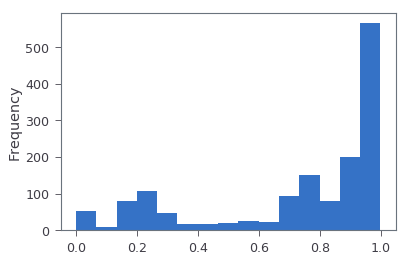

In [60]:
simMetricVals['similarity'].plot.hist(bins=15)

### Introducing blocking *volume* into metric.

While our first metric (above) gives us a good sense of blocking overlaps,
it fails to show us variation in the *volume* of blocking. Some countries have more blocking than others. We want to account for that.

We'll measure the volume of blocking in each country. We'll do that by measuring, for each country, the *proportion* of observations where `censored=True`.

We'll also measure the proportion of unique websites blocked (over unique websites tested).

We'll then take the average of the normalized scores of these two measurements.

By finding similarities in these scores, we'll produce a metric of similarity in website blocking volume.

Now we can compute the similarity in proportions between two countries.

In [345]:
# def get_proportion (cc2, 
#                     numerator='num_observations_blocked',
#                     denominator='num_observations',
#                    ):
#     row = metadata[metadata['alpha2']==cc2]
#     return (row[numerator]/row[denominator]).values[0]

# def compute_similarity(proportion1, proportion2):
#     if proportion1==0 or proportion2 ==0 and (proportion1 != proportion2):
#         return 0
#     return 1 - abs(proportion1 - proportion3)

# def min_max_norm(series):
#     return (series-series.min())/(series.max()-series.min())

# def compute_similarity_df (**kwargs):
#     CountSimilarity = []
#     for item in pairs:
#         (country1, country2) = item
#         similarity = compute_similarity(get_proportion(country1, **kwargs), get_proportion(country2, **kwargs))
#         CountSimilarity.append((item, similarity))
        
#     similarities =\
#         pd.DataFrame(CountSimilarity, columns=[
#             'pair',
#             'similarity'
#         ])
    
#     similarities['similarity-normalized'] =\
#         min_max_norm(similarities['similarity'])\
    
#     return similarities

In [61]:
# sims = compute_similarity_df()
# sims['similarity-normalized'].plot.hist()

In [62]:
# sims[sims['pair']==('US', 'RU')]

## 4c. Merging these two

In [63]:
# MetricDF = pd.merge(
#     simMetricVals,
#     sims,
#     on='pair',
#     how='outer')
MetricDF = simMetricVals.rename(columns={
    'similarity': 'Overall_Similarity',
#     'similarity':'Censored_Category_Similarity',
#     'similarity-normalized':'Blocking_Proportion_Similarity',
})
# MetricDF['Overall_Similarity'] = (MetricDF['Censored_Category_Similarity']+ MetricDF['Blocking_Proportion_Similarity'])/2
MetricDF = MetricDF.sort_values(by='Overall_Similarity',ascending=False)
MetricDF

,pair,country_code_alpha2_A,country_code_alpha2_B,Overall_Similarity
961,"(NO, DK)",NO,DK,0.998885
308,"(CO, PE)",CO,PE,0.998619
783,"(LT, NZ)",LT,NZ,0.998256
1085,"(RO, FR)",RO,FR,0.998055
417,"(FR, BE)",FR,BE,0.997712
...,...,...,...,...
1403,"(VE, DZ)",VE,DZ,0.000000
1404,"(VE, GR)",VE,GR,0.000000
20,"(AD, VE)",AD,VE,0.000000
1406,"(VE, LI)",VE,LI,0.000000


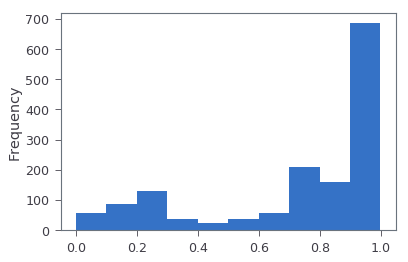

In [64]:
MetricDF['Overall_Similarity'].plot.hist()
plt.show()

In [65]:
# Add back in Alpha 3
iCA = MetricDF['country_code_alpha2_A']
iCB = MetricDF['country_code_alpha2_B']

countries = {}
for country in pycountry.countries:
    countries[country.alpha_2] = country.alpha_3


a3A = [countries.get(country, 'Unknown code') for country in iCA]
a3B = [countries.get(country, 'Unknown code') for country in iCB]

MetricDF['country_code_alpha3_A'] = a3A
MetricDF['country_code_alpha3_B'] = a3B

MetricDF = MetricDF.reset_index()
MetricDF = MetricDF.set_index('pair')

MetricDF = MetricDF.drop(columns=['index'])

## Generating CSV output

In [66]:
MetricDF.to_csv('../output/metrics.csv')

## Generating JSON output

*Dropping other columns for JSON conversion format compliance*

In [67]:
pairs_of_similarities = {}
for _, row in MetricDF.iterrows():
    countryA = row['country_code_alpha3_A']
    countryB = row['country_code_alpha3_B']
    country_pair = countryA +'->'+ countryB
    pairs_of_similarities[country_pair] = row.to_dict()

In [68]:
output_json = json.dumps(pairs_of_similarities)

In [69]:
with open('../output/metrics.json', 'w') as outfile:
    json.dump(output_json, outfile)

In [70]:
!cp ../output/metrics.json ~/Programs/interoperability-demo/data/data.json

# Section 3. Hypothesis testing

## Importing the Data

Importing the METRICDFJSON DataFrame

In [71]:
metrics = pd.read_csv("../output/metrics.csv")
metrics.shape

(1485, 6)

Importing non-Internet proxy data files

In [72]:
#Reading the NATO data
NATO = pd.read_pickle("../data/iclabcombined_and_hypothesis_data/NATO.pkl")
NATO.shape

(29, 2)

In [73]:
def change_code(input_countries):
    input_countries = input_countries.to_list()
    countries = {}
    for country in pycountry.countries:
        countries[country.name] = country.alpha_3
    codes = [countries.get(country, 'Unknown code') for country in input_countries]
    return codes

#Prepping the WEF Data
WEF = pd.read_csv("../data/iclabcombined_and_hypothesis_data/WEFCompIndex.csv",index_col=0)
WEF['code'] = change_code(WEF['Country'])
missCodes =['TWN','KOR','IRL','CZE','RUS','BRN','VNM','GEO','MDA','IRN','BOL','Unknown code','Unknown code','TZA','CIV','GMB','VEN','COD']
missIdxs = WEF[WEF['code']=='Unknown code'].index

for i in range(len(missIdxs)):
    WEF.at[missIdxs[i],'code']= missCodes[i]

WEF = WEF[['code','scores']]

WEF.shape

(141, 2)

In [74]:
#Prepping the Commonwealth Data
Commonwealth = pd.read_csv("../data/iclabcombined_and_hypothesis_data/CWdata.csv")
code = change_code(Commonwealth['COUNTRY'])
Commonwealth['code'] = code
Commonwealth.at[6,'code']= 'BRN'
Commonwealth.at[11,'code']= 'GMB'
Commonwealth.at[31,'code']= 'CYP'
Commonwealth.at[50,'code']= 'TZA'
Commonwealth = Commonwealth[Commonwealth['code']!='Unknown code']

Commonwealth.shape

(49, 2)

In [75]:
#Prepping the Media Freedom Data
MediaDF = pd.read_csv('../data/iclabcombined_and_hypothesis_data/PressFreedomIndex.csv').loc[:,['ISO','Score 2019','Rank 2019']].sort_values(by='Rank 2019',ascending=True).set_index("Rank 2019")
MediaDF['Score 2019'] = MediaDF['Score 2019'].apply(lambda x : x.replace(',','.') )
MediaDF['Score 2019'] = MediaDF['Score 2019'].astype(float)
MediaDF.rename(columns={'ISO':'code','Score 2019':'scores'},inplace=True)
MediaDF['scores'] = 100 - MediaDF['scores']

MediaDF.shape

(180, 2)

In [77]:
#Prepping the FIW (Freedom in the World) Data
Freedom = pd.read_csv('../data/iclabcombined_and_hypothesis_data/FH2018.csv')
code = change_code(Freedom['Country/Territory'])
Freedom['code'] = code
Freedom = Freedom[['code','Total']].rename(columns={'Total':'scores'})
Freedom = Freedom.sort_values(by='scores',ascending=False)
Freedom = Freedom[Freedom['code']!='Unknown code']
Freedom.shape

(174, 2)

## General purpose functions to test our hypothesis'.

We will be using the Mann Whitney U test to determine if two groups are similar to each other or not. This is a non-parametric test used for samples of at least size 20 when the samples dont originate from normal distributions. To learn more refer the link below:

[MannWhitneyUTest](https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/)

In [78]:
def correlation (df):
    blocking_sims = []
    wef_sims = []
    print('warn! no data on:', end=" ")
    
    def get_value (country):
        try:
            return df[df['code']==country].scores.values[0]
        except:
            print(country, end=' ')
            return 0
    
    for _, row in metrics.iterrows():
        country1 = row['country_code_alpha3_A']
        country2 = row['country_code_alpha3_B']
        country1_wef = get_value(country1)
        country2_wef = get_value(country2)
        sim = 100 - abs(country1_wef - country2_wef)
        wef_sim = sim/100
        wef_sims.append(wef_sim)
        blocking_sim = row['Overall_Similarity']
        blocking_sims.append(blocking_sim)
        
    deg_freedom = len(blocking_sims)-2
    (corr, p_val) = scipy.stats.pearsonr(blocking_sims, wef_sims)
    
    return {
        'corr': corr, 
        'p-value': p_val,
        'degrees of freedom': deg_freedom,
    }

In [79]:
def Hypo_Test_Groups(df):
    '''
    Parameters:
    Dataframe of non-interent proxy
    
    Used when our proxy measure buckets countries based on their presence or absence in a group e.g. NATO or CommonWealth
    Creates 2 buckets
    One for an edge where both vertices are countries that are members of a given group
    Another for an edge where one vertice belongs to member country and another to a non-member country.
    
    Returns:
    p value for the MannWhitneyU test run on these two buckets
    variances for these two buckets
    '''
    
    #List of countries which are in the Affinity group like NATO or Commonwealth
    AffinityGroup = df['code'].to_list()
    
    #Determining indexes of our two buckets
    #One bucket is for similar edges i.e. both countries are members of a group
    #The other bucket is for dissimilar edges i.e. while one country is a group member the other is not
    allIndex = metrics.index.to_list()
    nonMembersIndex =  (metrics[~((metrics['country_code_alpha3_A'].isin(AffinityGroup)) | (metrics['country_code_alpha3_B'].isin(AffinityGroup)))]).index.to_list()
    bothMembersIndex = (metrics[(metrics['country_code_alpha3_A'].isin(AffinityGroup)) & (metrics['country_code_alpha3_B'].isin(AffinityGroup))]).index.to_list()
    oneMemberIndex =  [idx for idx in allIndex if idx not in (nonMembersIndex+bothMembersIndex)]
    
    #Similarity scores for the two buckets
    Member2MemberScores = metrics.loc[bothMembersIndex]['Overall_Similarity'].to_list()
    Member2NonMemberScores = metrics.loc[oneMemberIndex]['Overall_Similarity'].to_list()
    
    #MannWhitneyUTest
    tScore,p = scipy.stats.mannwhitneyu(Member2MemberScores,Member2NonMemberScores,use_continuity=True,alternative='greater')
    testResults = {'test score':tScore, 'p Value':p}
    
    variancesDict = {
        'Varinace between Similiar Edges' : statistics.variance(Member2MemberScores),
        'Variance between Dissimilar Edges' : statistics.variance(Member2NonMemberScores),
    }
    
    mediansDict = {
        'Median of hyp. greater group': np.median(Member2MemberScores),
        'Median of hyp. less group': np.median(Member2NonMemberScores),
    }
    
    return testResults, variancesDict, mediansDict

## Military Alliance (NATO Members)

The North Atlantic Treaty Organization, also called the North Atlantic Alliance, is an intergovernmental military alliance between 30 North American and European countries

Learn More: 

[About NATO](https://en.wikipedia.org/wiki/Member_states_of_NATO)

In [80]:
#Checking the Data
NATO.head(3)

,CNTRY_NAME,code
0,Albania,ALB
1,Belgium,BEL
2,Bulgaria,BGR


Essentially testing - Countries are more similar to each other in Internet Censorship when they are NATO members as opposed to when one of them is a NATO member and the other isnt

**H0** - SIMILARITY SCORE FOR country pairs wherein both are memebers of NATO AND country pairs wherein one country is a member of NATO while the other isnt ARE SIMILIAR 
                          

H1 - SIMILARITY SCORES FOR country pairs wherein both are memebers of NATO IS GREATER THAN country pairs wherein one country is a member of NATO while the other isnt. 


In [81]:
Hypo_Test_Groups(NATO)

({'test score': 93709.0, 'p Value': 2.3951301489966563e-18},
 {'Varinace between Similiar Edges': 0.044531930749155256,
  'Variance between Dissimilar Edges': 0.08457638704727212},
 {'Median of hyp. greater group': 0.9718409531936592,
  'Median of hyp. less group': 0.8962783727756418})

Since the above p value is lesser than threshold(0.5), we can reject H0

Hence we can conclude that countries which are memebrs of NATO are more similar to each other than to countries which arent members of NATO

As expected non-members states have much higher variance than member states

## Economy (WEF Competitiveness Index)

The World Economic Forums Global Competitiveness Index measures the set of institutions, policies, and factors that set the sustainable current and medium-term levels of economic prosperity. The Global Competitiveness Index's annual reports are somewhat similar to the Ease of Doing Business Index.

Learn More:

[WEF 2019 Report](https://en.wikipedia.org/wiki/Global_Competitiveness_Report)

In [86]:
# Reading the Data
# WEF.head(3)
# wef_subset.head(3)

### Test 1: Correlation
We compute simliarities between WEF scores across country pairs. 

In [87]:
# correlation(WEF)

### Test 2: High-weight connections
Correlate WEF scores with # of high-weight connections for each country.

In [88]:
# # take only WEF countries for which we have data
# wef_subset = WEF.merge(
#     metrics.groupby('country_code_alpha3_A').count()['pair'],
#     left_on='code',
#     right_on='country_code_alpha3_A', 
#     how='right'
# ).drop(columns=['pair']).dropna()

# wef_subset.shape

In [377]:
# def correlate_by_threshold (thresh):
#     '''
#     For each country, count the number of weights which are greater than or equal to `thresh`.
    
#     Compute Pearson correlation between this number and WEF index.
#     '''

#     num_connections =\
#         metrics[metrics['Overall_Similarity']>=thresh]\
#             .groupby('country_code_alpha3_A')\
#             .count()[['Overall_Similarity']]
    
    
#     # merge WEF left to make sure we don't drop any countries that didn't meet threshold!
#     scores_to_conns = wef_subset.merge(num_connections, 
#                                 left_on='code',
#                                 right_on='country_code_alpha3_A', 
#                                 how='left', # use only keys from left df
#                                )\
#         .fillna(0) # any NaN values must have not met threshold above, and have 0 connections
    
#     deg_freedom = len(scores_to_conns)-2
#     (corr, p_val) = scipy.stats.pearsonr(
#         scores_to_conns['Overall_Similarity'].values, 
#         scores_to_conns['scores'].values, 
#     )
#     return {
#         'correlation': corr,
#         'p-value': p_val,
#         'deg-freedom': deg_freedom,
#     }

In [378]:
# quantile95 = metrics['Overall_Similarity'].quantile(0.95)
# quantile95

1.0

In [379]:
# correlate_by_threshold(quantile95)

{'correlation': 0.18214735111244473,
 'p-value': 0.19621991257519003,
 'deg-freedom': 50}

## EU

In [119]:
def to_country_df (country_list):

    ccs = pd.read_csv('../data/utils/countries_codes_and_coordinates.csv')
    
    cdf = []
    for name in country_list:
        try:
            alpha3cc = ccs[ccs['Country'] == name]['Alpha-3 code'].values[0][2:-1]
        except:
            pass
        cdf.append([name, alpha3cc])
    
    return pd.DataFrame(cdf, columns=['CNTRY_NAME', 'code'])

In [120]:
EU_western_bloc = [
'Austria',
'Belgium',
'Republic of Cyprus',
'Denmark',
'Finland',
'France',
'Germany',
'Greece',
'Ireland',
'Italy',
'Luxembourg',
'Malta',
'Netherlands',
'Portugal',
'Spain',
'Iceland',
'Norway',
'Sweden',
]



EU_eastern_bloc = [
'Croatia',
'Bulgaria',
'Poland',
'Hungary',
'Estonia',
'Latvia',
'Lithuania',
'Romania',
'Slovakia',
'Slovenia',
'Czech Republic',
]

In [122]:
EU = EU_western_bloc + EU_eastern_bloc

In [124]:
EU = to_country_df(EU)

In [125]:
Hypo_Test_Groups(EU)

({'test score': 99666.0, 'p Value': 2.436867818297719e-26},
 {'Varinace between Similiar Edges': 0.004004621794242238,
  'Variance between Dissimilar Edges': 0.08347596193500928},
 {'Median of hyp. greater group': 0.9714044190122644,
  'Median of hyp. less group': 0.8975208589707833})

In [126]:
Hypo_Test_Groups(to_country_df(EU_western_bloc))

({'test score': 32701.0, 'p Value': 9.385629492817328e-15},
 {'Varinace between Similiar Edges': 0.0006587075095761508,
  'Variance between Dissimilar Edges': 0.0765169394161586},
 {'Median of hyp. greater group': 0.9763936656212899,
  'Median of hyp. less group': 0.9258044676803503})

In [127]:
Hypo_Test_Groups(to_country_df(EU_eastern_bloc))

({'test score': 4327.0, 'p Value': 0.040895925351540095},
 {'Varinace between Similiar Edges': 0.008129016293259479,
  'Variance between Dissimilar Edges': 0.0670128207045829},
 {'Median of hyp. greater group': 0.96855711861864,
  'Median of hyp. less group': 0.9257906662066757})

## ASEAN

In [112]:
ASEAN = to_country_df([
'Indonesia', 
'Thailand', 
'Malaysia', 
'Singapore', 
'Philippines', 
'Vietnam', 
'Brunei', 
'Cambodia', 
'Myanmar', 
'Laos',
])
ASEAN

,CNTRY_NAME,code
0,Indonesia,IDN
1,Thailand,THA
2,Malaysia,MYS
3,Singapore,SGP
4,Philippines,PHL
5,Vietnam,VNM
6,Brunei,BRN
7,Cambodia,KHM
8,Myanmar,MMR
9,Laos,MMR


In [113]:
Hypo_Test_Groups(ASEAN)

({'test score': 814.0, 'p Value': 0.08479598840191321},
 {'Varinace between Similiar Edges': 0.004172228145725306,
  'Variance between Dissimilar Edges': 0.05104646471750351},
 {'Median of hyp. greater group': 0.8183288786858869,
  'Median of hyp. less group': 0.7621204846061269})

## Historical relationships (Commonwealth Members)

The Commonwealth of Nations is a political association of 54 member states, nearly all former territories of the British Empire. Member states have no legal obligations to one another, but are connected through their use of the English language and historical ties.

Learn More:
[Commonwealth of Nations](https://en.wikipedia.org/wiki/Commonwealth_of_Nations)

In [91]:
#Reading the Data
Commonwealth.head(3)

,COUNTRY,code
0,Antigua and Barbuda,ATG
1,Australia,AUS
2,Bangladesh,BGD


Essentially testing - Countries are more similar to each other in Internet Censorship when they are culturally aligned (e.g. both are Commonwealth nations) as opposed to when one of them is a Commonwealth member and the other isnt

**H0** - SIMILARITY SCORE FOR country pairs wherein both are memebers of Commonwealth AND country pairs wherein one country is a member of Commonwealth while the other isnt ARE SIMILIAR 
                          

H1 - SIMILARITY SCORES FOR country pairs wherein both are memebers of Commonwealth IS GREATER THAN country pairs wherein one country is a member of Commonwealth while the other isnt. 


In [92]:
Hypo_Test_Groups(Commonwealth)

({'test score': 9922.0, 'p Value': 0.5880120810986699},
 {'Varinace between Similiar Edges': 0.08164443947702109,
  'Variance between Dissimilar Edges': 0.0871937823666309},
 {'Median of hyp. greater group': 0.8888904498201586,
  'Median of hyp. less group': 0.8905603352785265})

Since the above p value is greater than threshold(0.5), we CAN NOT reject H0

Hence we CAN NOT SAY that countries which are memebrs of commonwealth are more similar to each other than to countries which arent members of COMMONWEALTH.

Chances are a country could be as similar to a member of commonwealth in terms of its internet censorship as it could be to a non member

The variance calculated for these two buckets also demonstrates the same

## Media Freedom (World Freedom of Press Index)

The WORLD PRESS FREEDOM INDEX by Reporters Without Borders ranks 180 countries and regions according to the level of freedom available to journalists. It is a snapshot of the media freedom situation based on an evaluation of pluralism, independence of the media, quality of legislative framework and safety of journalists in each country and region.

Learn More:

Reporters Without Borders Report [2019 Ranking](https://rsf.org/en/ranking/2019)



In [93]:
#Reading the Data
MediaDF.head(3)

,code,scores
Rank 2019,,
1,NOR,92.18
2,FIN,92.10
3,SWE,91.69


In [94]:
correlation(MediaDF)

warn! no data on: 

{'corr': 0.36011982117527797,
 'p-value': 1.0654525946750461e-46,
 'degrees of freedom': 1483}

## Civil Rights and Freedom  (Freedom in the World Index)

The Quality of Nationality Index (QNI) ranks the objective quality of nationalities worldwide. It explores three internal factors (economic strength, human development, and peace and stability) and four external factors (diversity and weight of travel freedom and diversity and weight of settlement freedom) which are used to measure the value of virtually all nationalities worldwide

Learn More:

[QNI website](https://www.nationalityindex.com/)

[Wiki Page](https://en.wikipedia.org/wiki/The_Quality_of_Nationality_Index)

Freedom in the World is Freedom House's flagship annual report, assessing the condition of political rights and civil liberties around the world. For each country and territory, Freedom in the World analyzes the electoral process, political pluralism and participation, the functioning of the government, freedom of expression and of belief, associational and organizational rights, the rule of law, and personal autonomy and individual rights.

Learn More:

[FIW 2018 Report](https://freedomhouse.org/sites/default/files/2020-02/FreedomintheWorld2018COMPLETEBOOK.pdf)

In [95]:
#Reading the Data
Freedom.head(3)

,code,scores
135,NOR,100
61,FIN,100
176,SWE,100


In [96]:
correlation(Freedom)

warn! no data on: MDA MDA MDA MDA MDA MDA MDA MDA MDA MDA MDA CZE MDA MDA MDA MDA CZE MDA MDA MDA CZE CZE MDA MDA CZE MDA CZE CZE MDA CZE MDA CZE MDA MDA CZE CZE CZE MDA CZE CZE MDA CZE CZE MDA CZE MDA CZE CZE CZE MDA MDA CZE CZE CZE MDA CZE MDA CZE CZE CZE CZE CZE CZE CZE CZE CZE MDA CZE VNM CZE MDA CZE VNM TWN MDA TWN MDA TWN TWN MDA TWN TWN TWN KOR TWN CZE TWN TWN TWN TWN TWN TWN TWN TWN TWN TWN CZE TWN MDA TWN TWN TWN TWN TWN TWN TWN TWN VNM TWN TWN VNM VNM TWN TWN CZE TWN VNM TWN VNM TWN CZE VNM TWN TWN TWN VNM VNM CZE TWN CZE TWN MDA VNM VNM VNM VNM VNM VNM VNM MDA VNM VNM VNM VNM VNM MDA VNM TWN MDA VNM CZE VNM VNM VNM VNM VNM VNM VNM CZE KOR CZE CZE MDA VNM VNM VNM VNM VNM VNM VNM VNM VNM VNM TWN TWN MDA MDA VNM VNM CZE TWN TWN TWN RUS MDA VNM VNM TWN TWN VNM CZE RUS MDA VNM KOR RUS TWN RUS RUS CZE RUS RUS MDA RUS RUS CZE KOR CZE KOR RUS KOR MDA MDA RUS RUS RUS VNM RUS RUS RUS CZE RUS TWN RUS RUS RUS RUS RUS RUS RUS RUS RUS RUS RUS RUS TWN RUS MDA RUS RUS RUS RUS RUS RUS TWN RU

{'corr': 0.42507787274426784,
 'p-value': 3.220493082523334e-66,
 'degrees of freedom': 1483}

In [103]:
media_freedom = MediaDF.merge(Freedom, on='code')
a = media_freedom['scores_x']
b = media_freedom['scores_y']
deg_freedom = len(a)-2
(corr, p_val) = scipy.stats.pearsonr(a, b)

deg_freedom, corr, p_val

(156, 0.8466930457797548, 1.3442786113729712e-44)